In [1]:
import numpy as np
from pytisean import tiseanio
from datasets import *
from matplotlib import pyplot as plt
from curvature import *
from subprocess import call
import pandas as pd
import os
print(os.getcwd())

params = {'legend.fontsize': 12,
          'legend.handlelength': 2}
plt.rcParams.update(params)

/home/varad/Dropbox/Data and Topology/code/d2-experiments


In [2]:
def plot_d2(d2,dims, filename, limits, start_dim=1):
    
    data_per_dim = int(d2.shape[0] / dims)
    plt.figure(figsize=(12,8), dpi=300)
    for dim in range(start_dim,dims+1):
        
        idx = (np.where(np.logical_and(d2[(dim-1)* (data_per_dim):(dim * data_per_dim),0] >= limits[0],
                            d2[(dim-1)* (data_per_dim):(dim * data_per_dim),0] < limits[1])))
        
        [p, COV] = np.polyfit(d2[(dim-1)* (data_per_dim):(dim * data_per_dim),0][idx], 
                 d2[(dim-1)* data_per_dim:(dim * data_per_dim),1][idx], deg=1, cov=True)
        
        plt.plot(d2[(dim-1)* (data_per_dim):(dim * data_per_dim),0], 
                 d2[(dim-1)* data_per_dim:(dim * data_per_dim),1], '.', 
                 #label=r'm=%d, d2=%.2f $\pm$ %.2f' % (dim, p[0], np.sqrt(COV[0][0])))
                 label=r'm=%d, d2=%.2f' % (dim, p[0]))

        #x_coord = np.arange(limits[0],limits[1],0.1)
        #y_coord = x_coord * p[0] + p[1]
        
        #plt.plot(x_coord, y_coord, color='black')
        plt.axvline(x=limits[0], color='black')
        plt.axvline(x=limits[1], color='black')
        
    plt.xticks(fontsize=20)
    plt.yticks(fontsize=20)
    plt.xlabel(r'log ($\epsilon$)', fontsize=20)
    plt.ylabel(r'log (C($\epsilon$))', fontsize=20)    
    plt.legend(prop={'size': 16})
    plt.savefig(filename)
    print("Saving as ", filename)
    plt.show()
    
    
def fit_slopes(d2, dims, limits):
    data_per_dim = int(d2.shape[0] / dims)
    print(limits)
    for dim in range(1,dims+1):
        
        idx = (np.where(np.logical_and(d2[(dim-1)* (data_per_dim):(dim * data_per_dim),0] >= limits[0],
                            d2[(dim-1)* (data_per_dim):(dim * data_per_dim),0] < limits[1])))
        
        [p, COV] = np.polyfit(d2[(dim-1)* (data_per_dim):(dim * data_per_dim),0][idx], 
                 d2[(dim-1)* data_per_dim:(dim * data_per_dim),1][idx], deg=1, cov=True)
        print(r'embedding dim={}, correlation dimension={}+/-{}'.format(dim, p[0], np.sqrt(COV[0][0])))
        
        

# Lorenz Full

In [3]:
n=100000
step_size=0.01
ds_rate = 1
#n=100000
#timestep=0.05
noise_level = 0.0

[t,data] = get_lorenz(n=n,timestep=step_size)

max_val  = np.zeros(3)
for i in range(3):
    max_val[i] = np.max((data[:,0])) - np.min((data[:,0]))
    
for i in range(3):
    print(max_val[i])
    data[:,i] = data[:,i] + noise_level*max_val[i]*(np.random.random((data.shape[0])) - .5)
    
lorenzTS = data[:,0]
print(lorenzTS.shape)

#max_val = [np.max((data[:,i])) - np.min((data[:,i])) for i in range(3)]
#print(max_val)

(100000, 3)
37.67964806925325
37.67964806925325
37.67964806925325
(90000,)


271
Additional non-data files were created
/home/varad/Dropbox/Data and Topology/code/d2-experiments
Saving as  d2_figures_paper/lorenz_full_noise_0.0_limits_-1.5_1.png


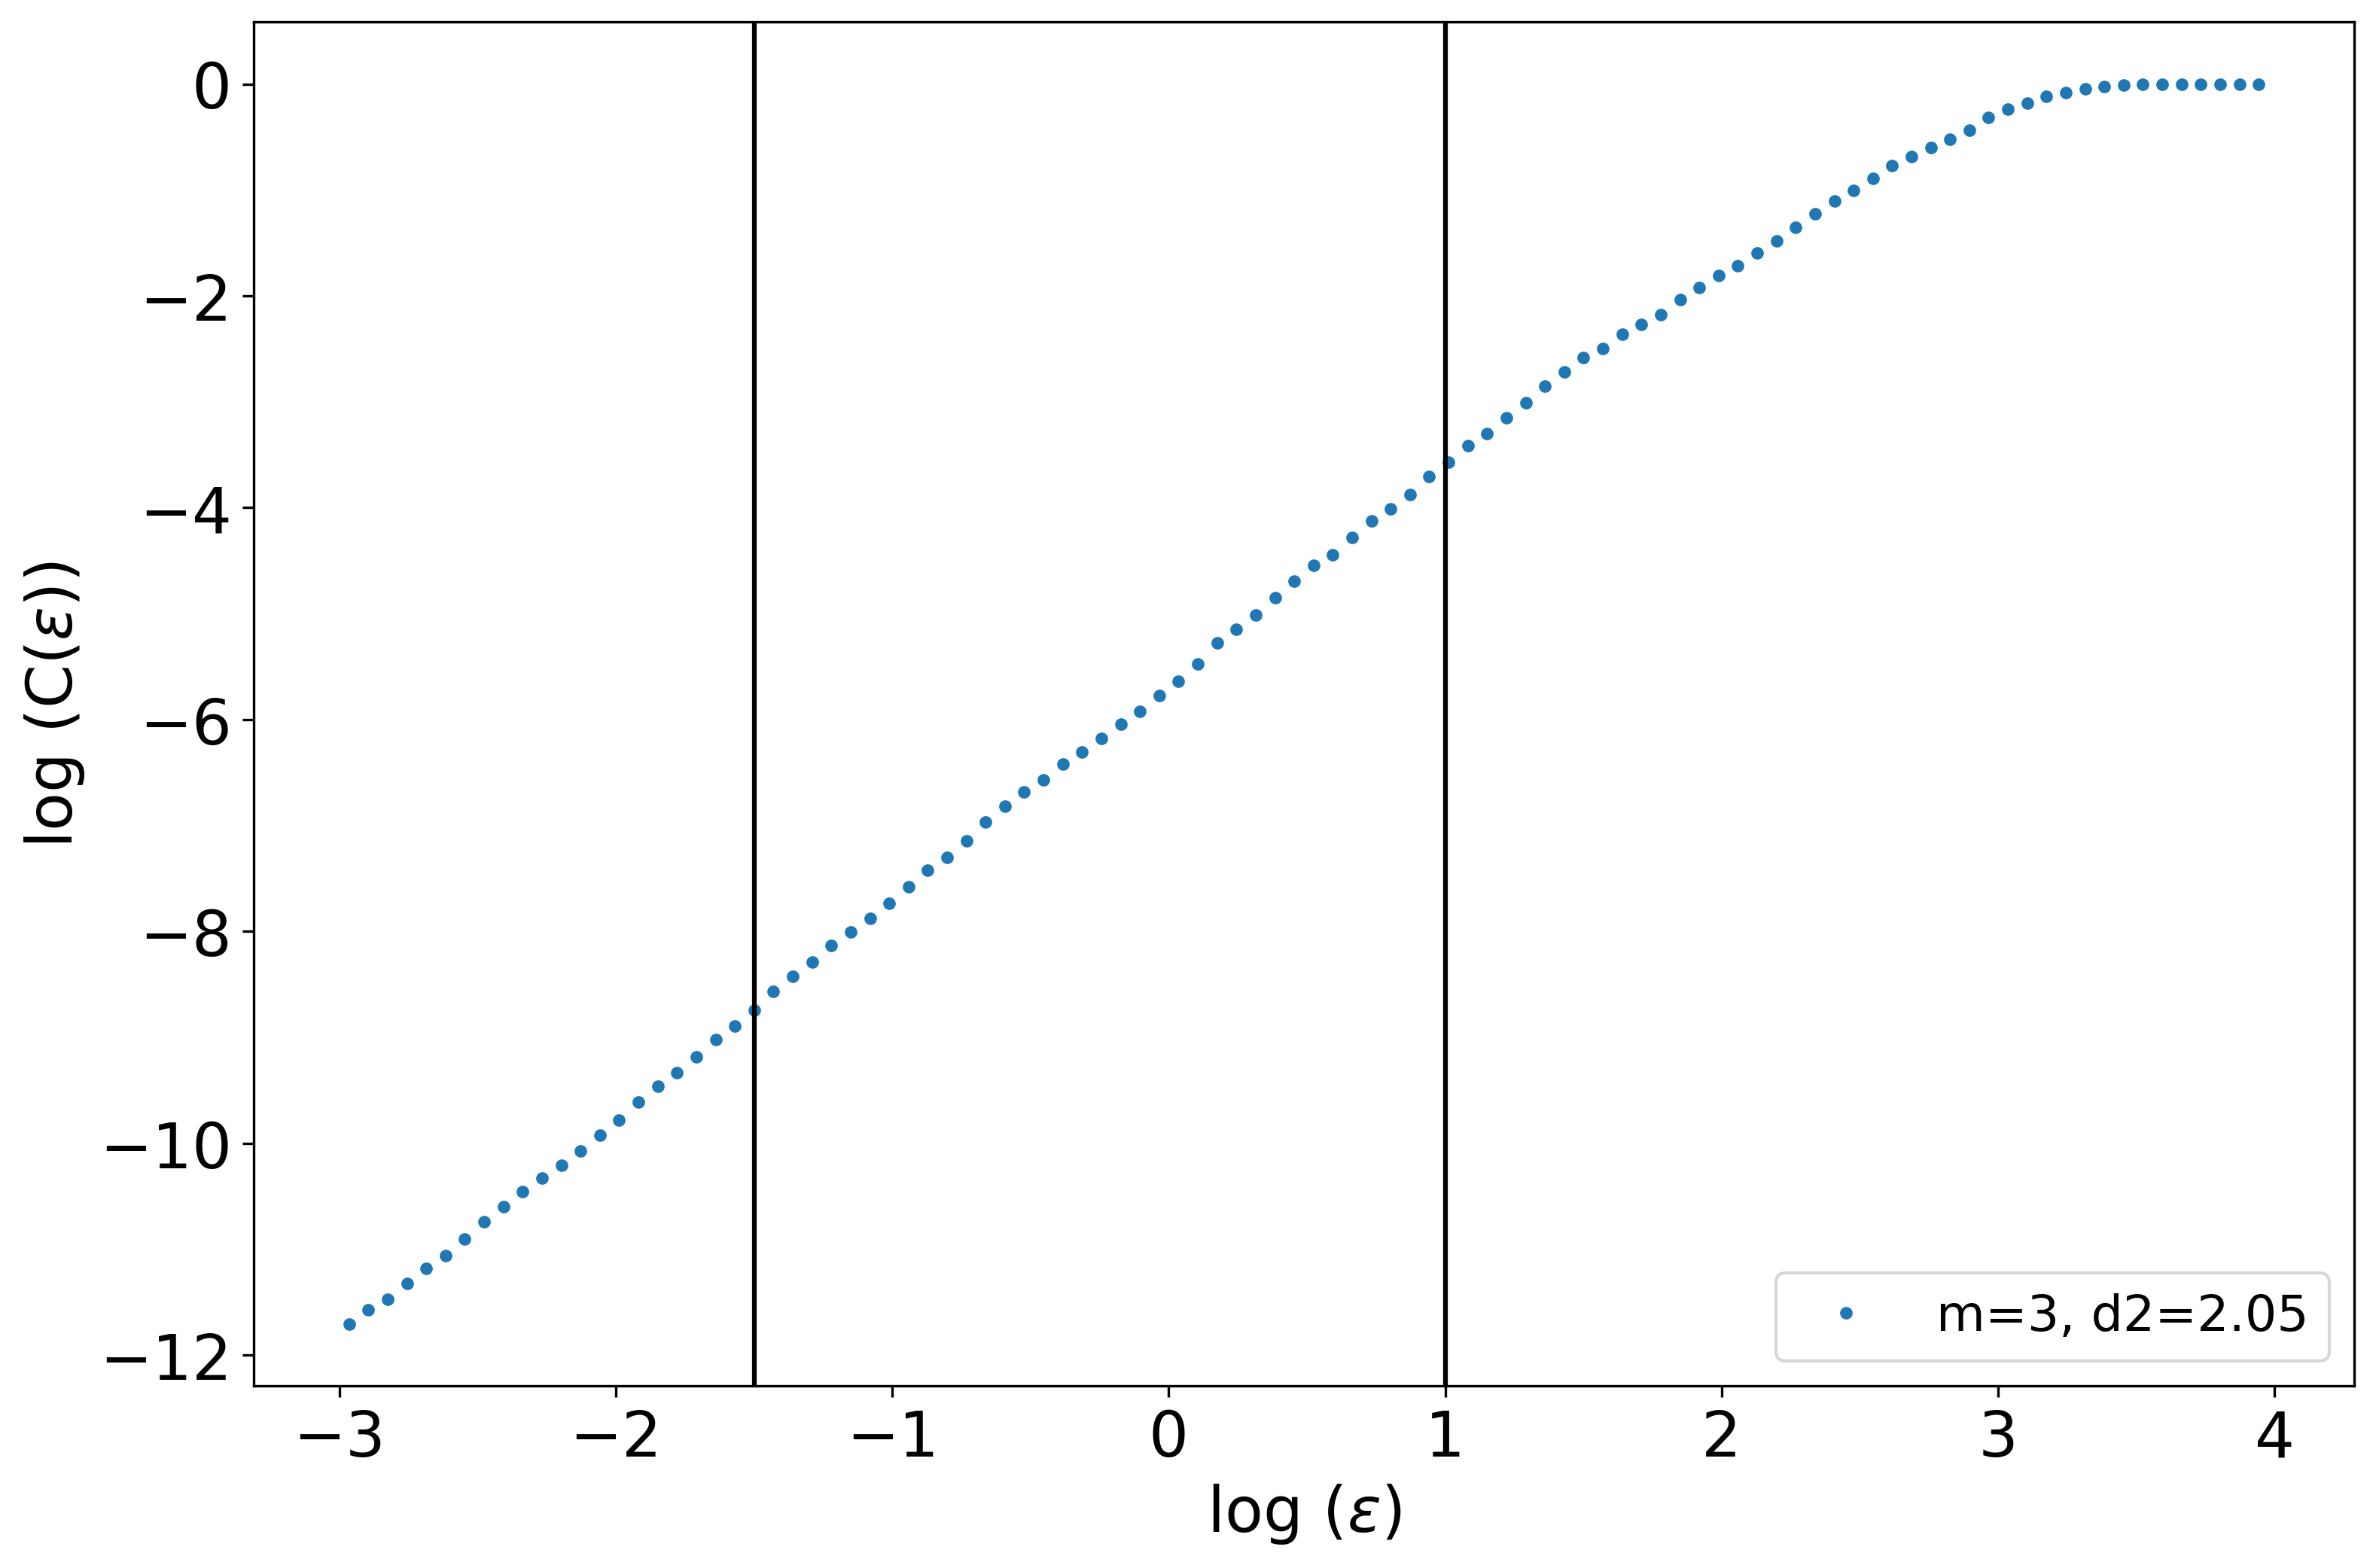

[-1.5, 1]
embedding dim=1, correlation dimension=0.9972419217636925+/-0.0022942082294438323
embedding dim=2, correlation dimension=1.6794194488063745+/-0.01100546667716556
embedding dim=3, correlation dimension=2.0455991852955733+/-0.0063205700944063215


In [4]:
limits=[-1.5,1]
#limits = [0.8,1.6]
dims = 3
#plt.plot(data[:,0],data[:,1],'.',markersize=.1)
#plt.xlabel('X')
#plt.ylabel('Y')
#plt.savefig('lorenz_projection_noise_{}.png'.format(noise_level))

theiler_window = int(2.718**limits[-1]/step_size/ds_rate)
print(theiler_window)
corr = tiseanio('d2','-M','3,1','-c','1,2,3', '-t', theiler_window, data=data, silent=True)

c2 = corr[0]['c2']
#log_c2 = np.concatenate((np.log(c2[:,0]).reshape(-1,1), np.log(c2[:,1]).reshape(-1,1)), axis=1)
log_c2 = np.log(c2)
print(os.getcwd())
plot_d2(log_c2, dims, 'd2_figures_paper/lorenz_full_noise_{}_limits_{}_{}.png'.format(noise_level, limits[0], limits[1]), limits, start_dim=3)
fit_slopes(log_c2, dims, limits)

In [5]:
tau_max = 100

'''
menger_mean = []
menger_variance = []
for tau in range(1,1000):
    menger = get_menger_centered_avg_embed(embed, 1, 0)
    menger_mean.append(np.mean(menger))
    menger_variance.append(np.var(menger))
'''
def get_menger_tau(data, tau_max):
    menger = [];
    dim = 2
    tau_avg = 1
    n_neighbors = 0
    menger_params = np.array([data.shape[0], 2, tau_max, tau_avg, n_neighbors])
    np.savetxt('menger_params.txt', menger_params)
    np.savetxt('menger_in.txt', data);
    np.savetxt('menger_params.txt', menger_params, fmt="%d")
    
    call(["./menger", "menger_in.txt", "menger_out.txt", "menger_params.txt"])
    menger_data = np.loadtxt("menger_out.txt");
    return menger_data[:,0], menger_data[:,1]

def moving_average(x, window = 4):
    
    s = pd.Series(x)
    s_ma = s.rolling(window).mean()

    return (np.array(s_ma)[window:])

lorenzTS_ma = moving_average(lorenzTS, window=20)

mutual_ma, err = tiseanio('mutual', '-D', tau_max, data=lorenzTS_ma)
mutual, err = tiseanio('mutual', '-D', tau_max, data=lorenzTS)
#embed, err = tiseanio('delay', '-m', 2, '-d', tau, data=lorenzTS, silent=True)

[menger_mean, menger_var] = get_menger_tau(lorenzTS_ma, tau_max)


TISEAN 3.0.1 (C) R. Hegger, H. Kantz, T. Schreiber (1998-2007)

mutual: Estimates the time delayed mutual information
	of the data set

Using /tmp/pytisean_temp_2020-04-12-18-35-59_hg_8mcuz/inFile as datafile, reading column 1
Use 89980 lines.
Opened /tmp/pytisean_temp_2020-04-12-18-35-59_hg_8mcuz/outFile for writing


TISEAN 3.0.1 (C) R. Hegger, H. Kantz, T. Schreiber (1998-2007)

mutual: Estimates the time delayed mutual information
	of the data set

Using /tmp/pytisean_temp_2020-04-12-18-36-00_cm9390k8/inFile as datafile, reading column 1
Use 90000 lines.
Opened /tmp/pytisean_temp_2020-04-12-18-36-00_cm9390k8/outFile for writing



In [9]:
print(mutual[0,1], menger_mean[0])
print(menger_mean[15:50])
print(mutual[15:45, 1])
print(mutual[50:80, 1])

2.586022 1.77399
[0.220828 0.218395 0.217612 0.218476 0.221041 0.22542  0.231801 0.240463
 0.251829 0.266644 0.28608  0.311825 0.346571 0.395407 0.469384 0.571112
 0.66924  0.737    0.770071 0.767833 0.746235 0.704771 0.670154 0.631513
 0.599968 0.561404 0.534182 0.496904 0.466074 0.439497 0.41794  0.397091
 0.376665 0.357179 0.338076]
[0.7747714 0.7611834 0.7539717 0.7527583 0.7537521 0.7569925 0.7679416
 0.7695793 0.7711562 0.777786  0.7811865 0.788848  0.7927069 0.7994662
 0.8043806 0.8059263 0.8057592 0.8004874 0.7906756 0.7768005 0.7607425
 0.7430476 0.7218961 0.697685  0.6680463 0.6381723 0.6089178 0.5806494
 0.5531525 0.5258167]
[0.3687724 0.3473694 0.3288853 0.3098102 0.2937027 0.2781728 0.2633277
 0.2513008 0.2429378 0.2347834 0.2303734 0.2306334 0.237541  0.2536062
 0.2754394 0.3019772 0.3306728 0.3595317 0.3857632 0.4087693 0.4278442
 0.44421   0.4580067 0.4684307 0.4717348 0.4712091 0.4708045 0.4705022
 0.4666344 0.4558636]


No handles with labels found to put in legend.


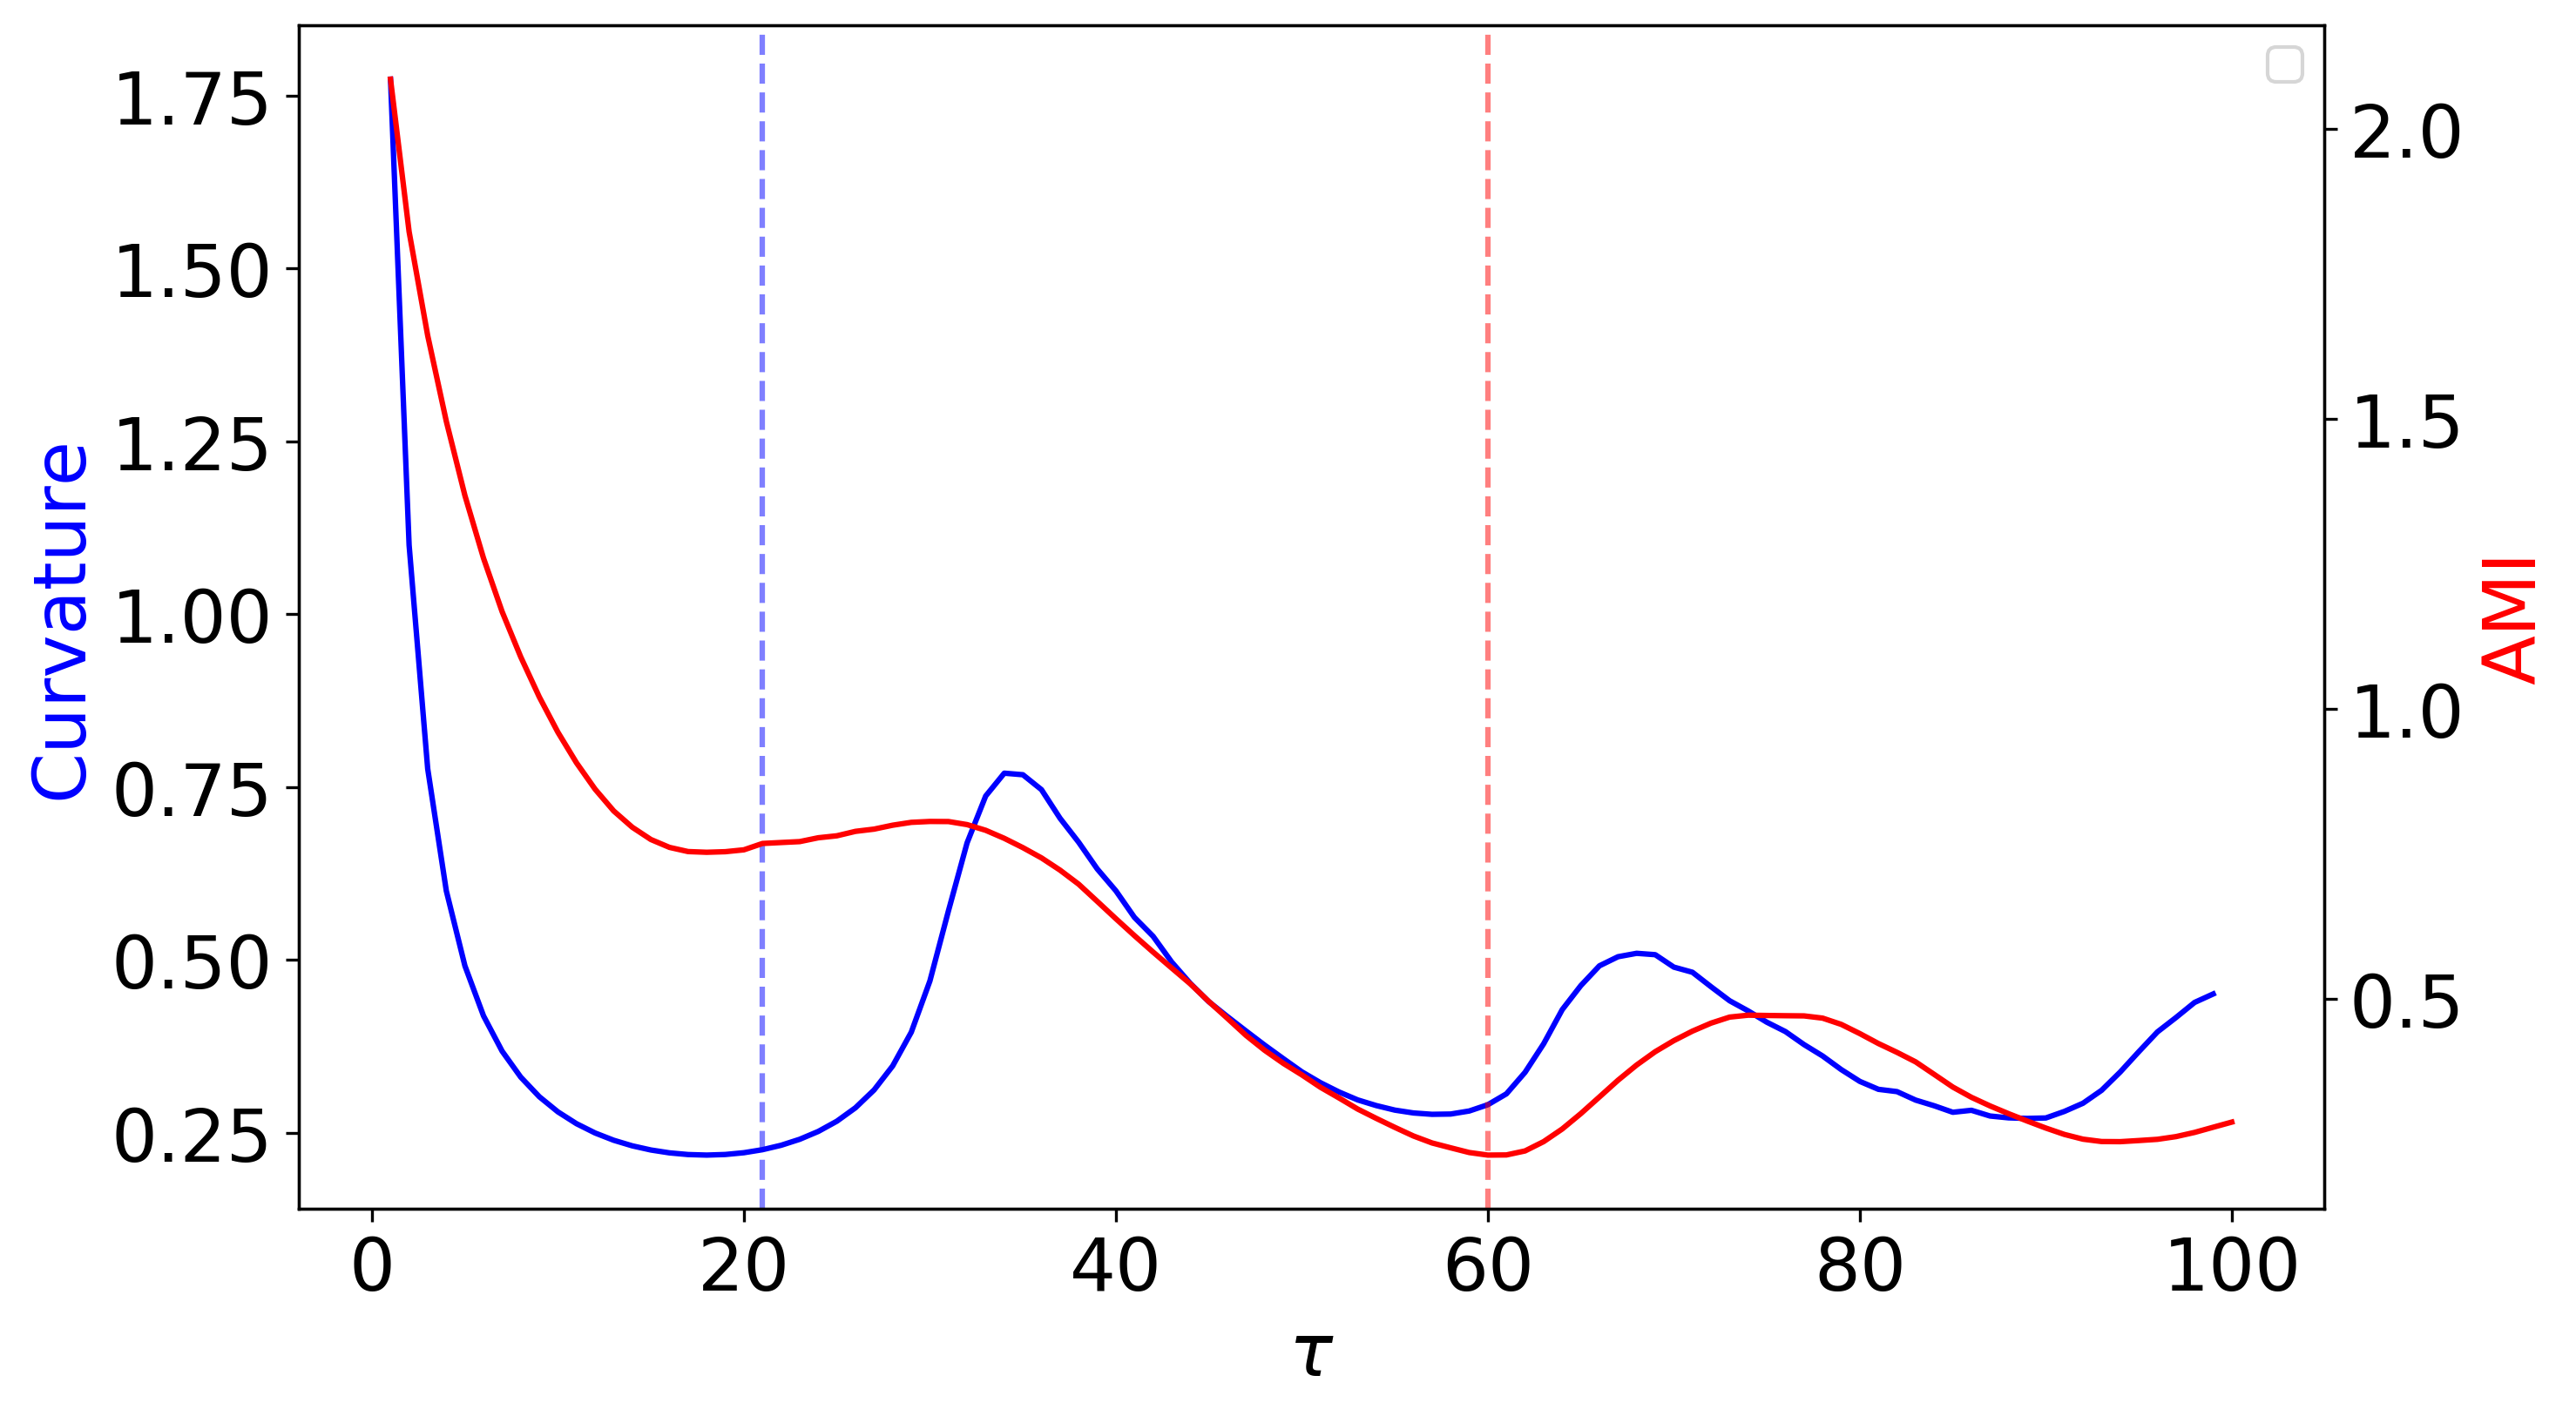

In [26]:
fig, ax1 = plt.subplots(figsize=(10,6), dpi=300)

#plt.plot(menger_var, label = 'curvature variance')
ax1.plot(np.arange(1,tau_max), menger_mean[:], color='b')
ax1.set_xlabel(r'$\tau$', fontsize=20)
ax1.set_ylabel(r'Curvature', color='b', fontsize=20)
ax2 = ax1.twinx()
ax2.plot(mutual[1:,0], mutual[1:,1], color = 'r')
ax2.set_ylabel(r'AMI', color='r', fontsize=20)
ax1.axvline(x = 21, color='b', linestyle='--', alpha=0.5)
ax2.axvline(x = 60, color='r', linestyle='--', alpha=0.5)
ax1.xaxis.set_tick_params(labelsize=20)
ax1.yaxis.set_tick_params(labelsize=20)
ax2.yaxis.set_tick_params(labelsize=20)
plt.legend()
plt.savefig('d2_figures_paper/lorenz_measures_vs_tau_noise_{}.png'.format(noise_level))#
#plt.savefig('lorenz_measures_vs_tau_noise_{}.png'.format(noise_level))

No handles with labels found to put in legend.



TISEAN 3.0.1 (C) R. Hegger, H. Kantz, T. Schreiber (1998-2007)

corr: Estimates the autocorrelations of a data set

Using /tmp/pytisean_temp_2020-04-14-21-59-58_eiw83qld/inFile as datafile, reading column 1
Use 90000 lines.
Opened /tmp/pytisean_temp_2020-04-14-21-59-58_eiw83qld/outFile for writing



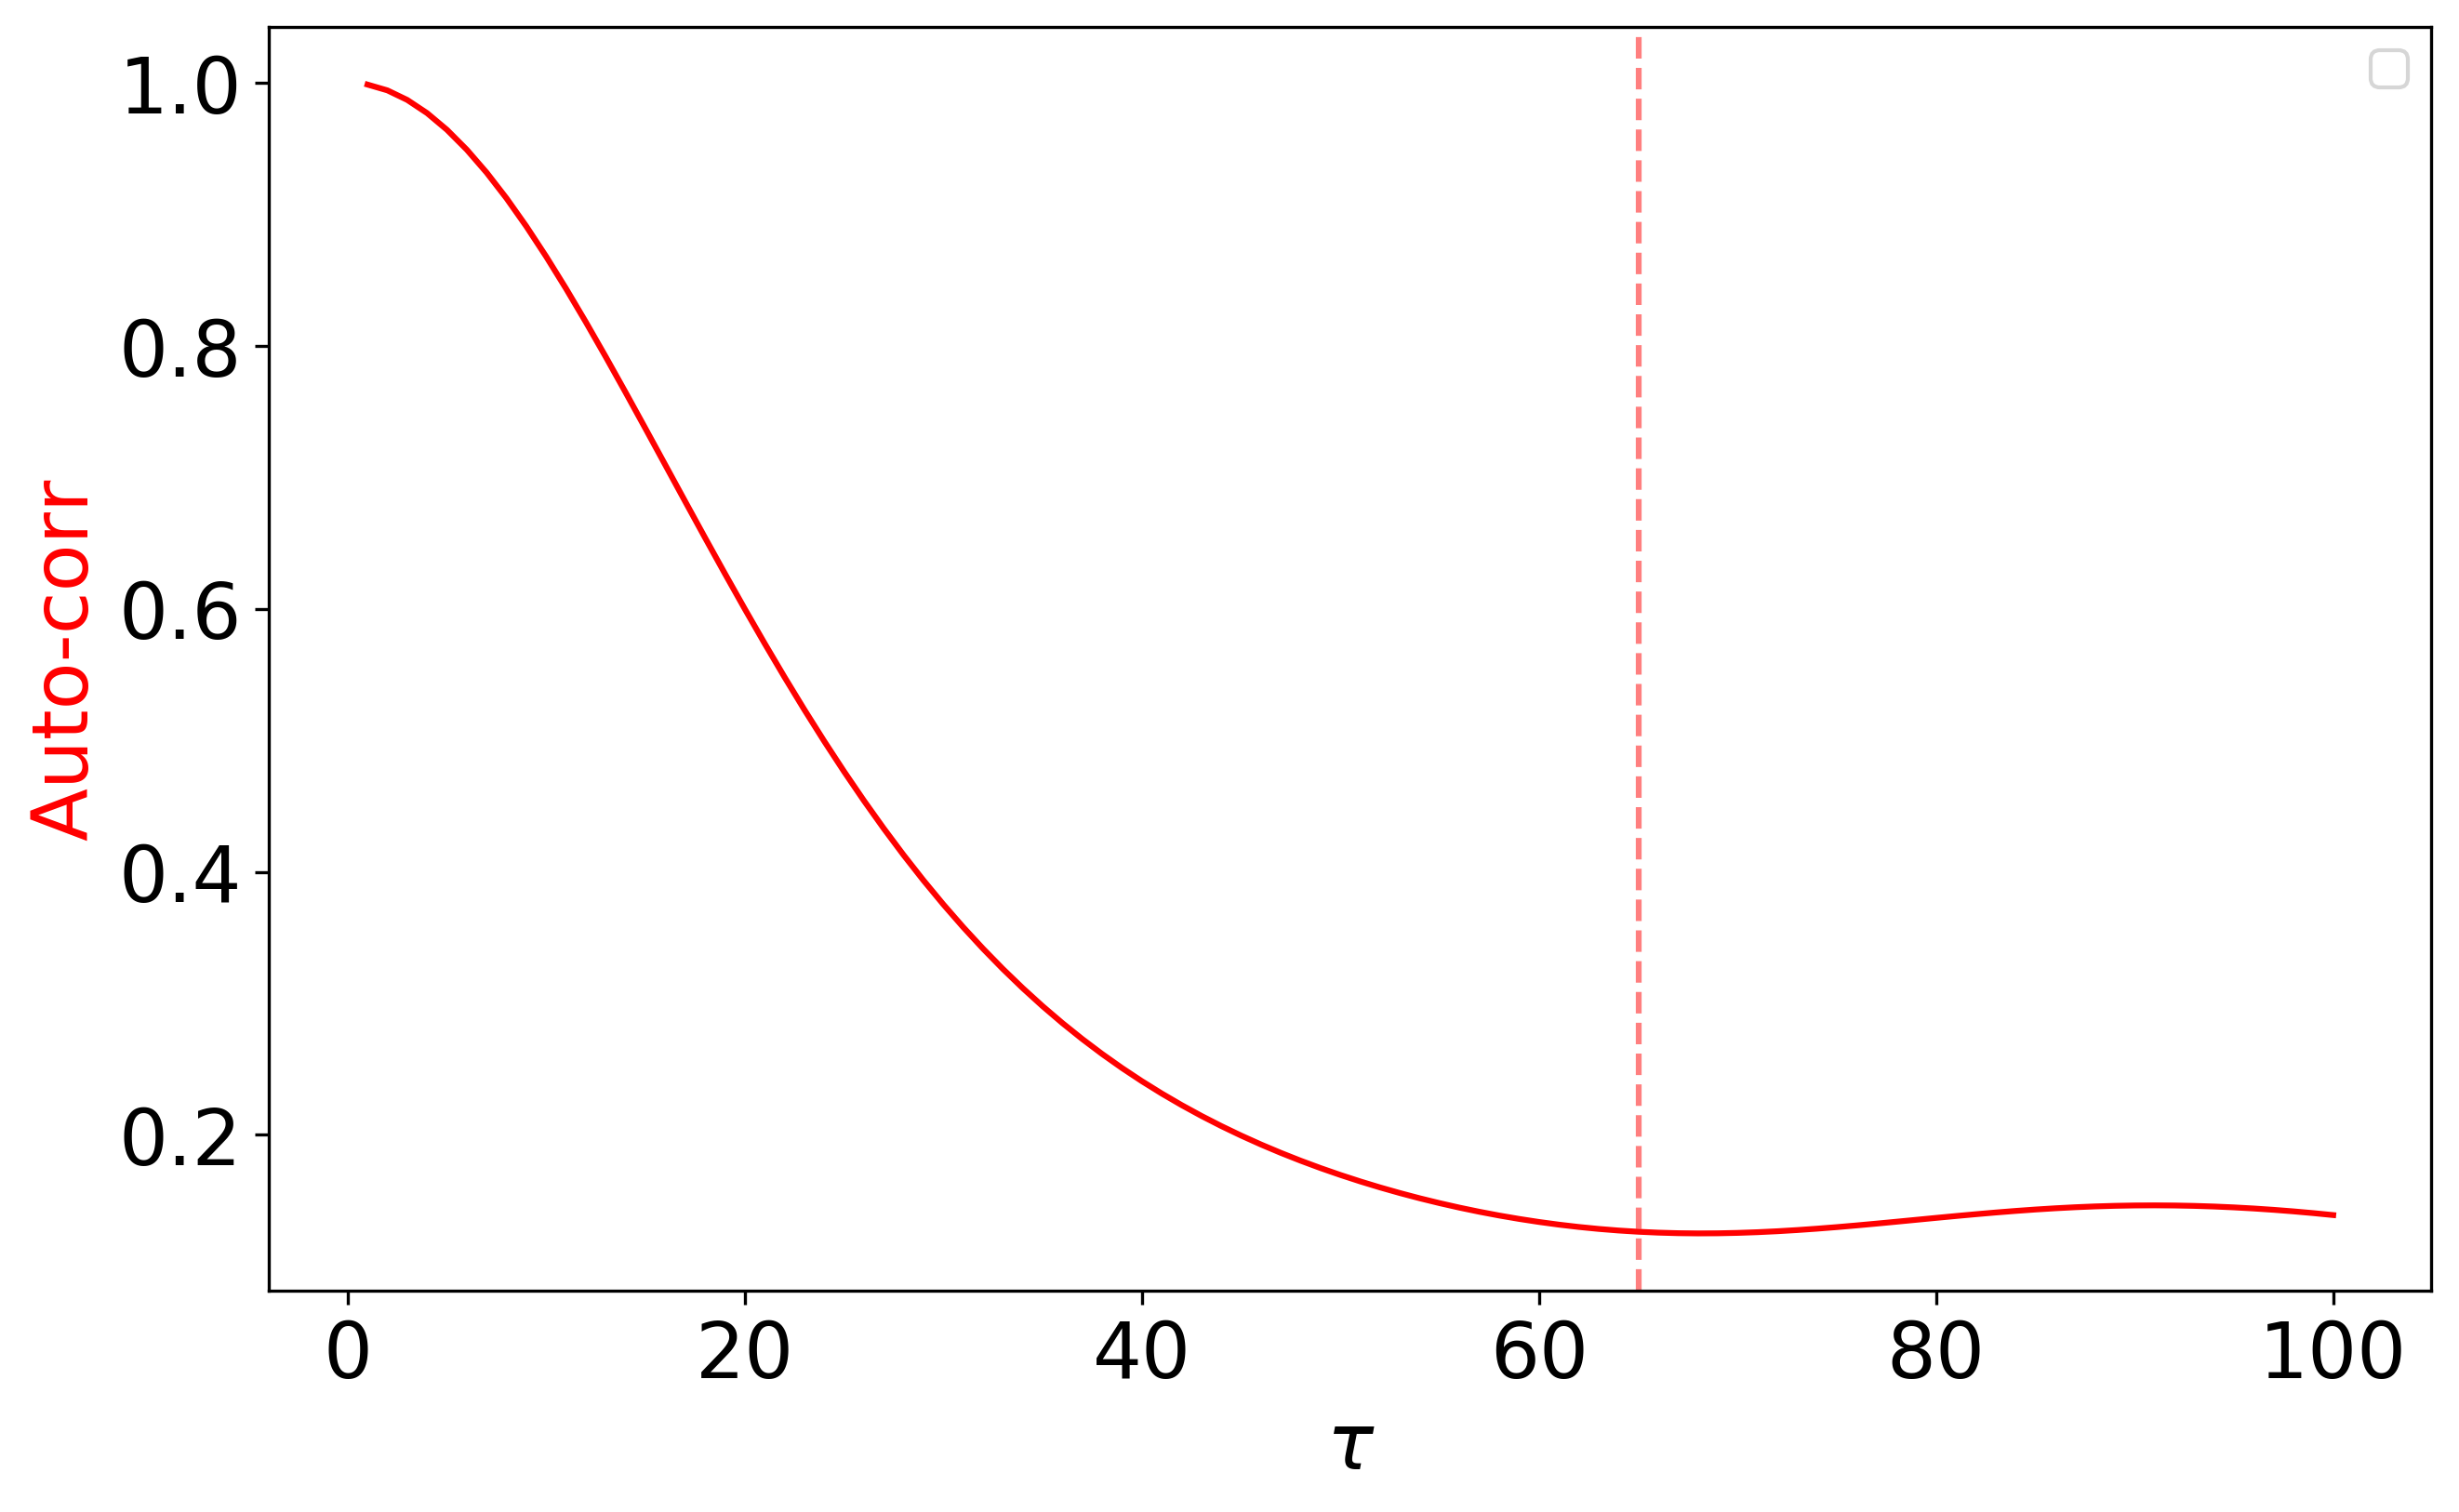

In [28]:
corr_ma, err = tiseanio('corr', '-D', 100, data=lorenzTS)
fig, ax1 = plt.subplots(figsize=(10,6), dpi=300)

#plt.plot(menger_var, label = 'curvature variance')
#ax1.plot(np.arange(1,tau_max), menger_mean[:], color='b')
ax1.set_xlabel(r'$\tau$', fontsize=20)
#ax1.set_ylabel(r'Curvature', color='b', fontsize=20)
#ax2 = ax1.twinx()
ax1.plot(corr_ma[1:,0], corr_ma[1:,1], color = 'r')
ax1.set_ylabel(r'Auto-corr', color='r', fontsize=20)
#ax1.axvline(x = 21, color='b', linestyle='--', alpha=0.5)
ax1.axvline(x = 65, color='r', linestyle='--', alpha=0.5)
ax1.xaxis.set_tick_params(labelsize=20)
ax1.yaxis.set_tick_params(labelsize=20)
ax2.yaxis.set_tick_params(labelsize=20)
plt.legend()
plt.savefig('d2_figures_paper/corr/lorenz_measures_vs_tau_noise_{}.png'.format(noise_level))#
#plt.savefig('lorenz_measures_vs_tau_noise_{}.png'.format(noise_level))

# Lorenz tau = 18 (Curvature)

164
Additional non-data files were created
Saving as  d2_figures_paper/lorenz_curvature_tau_18_noise_0.0_limits_-2.0_0.5.png


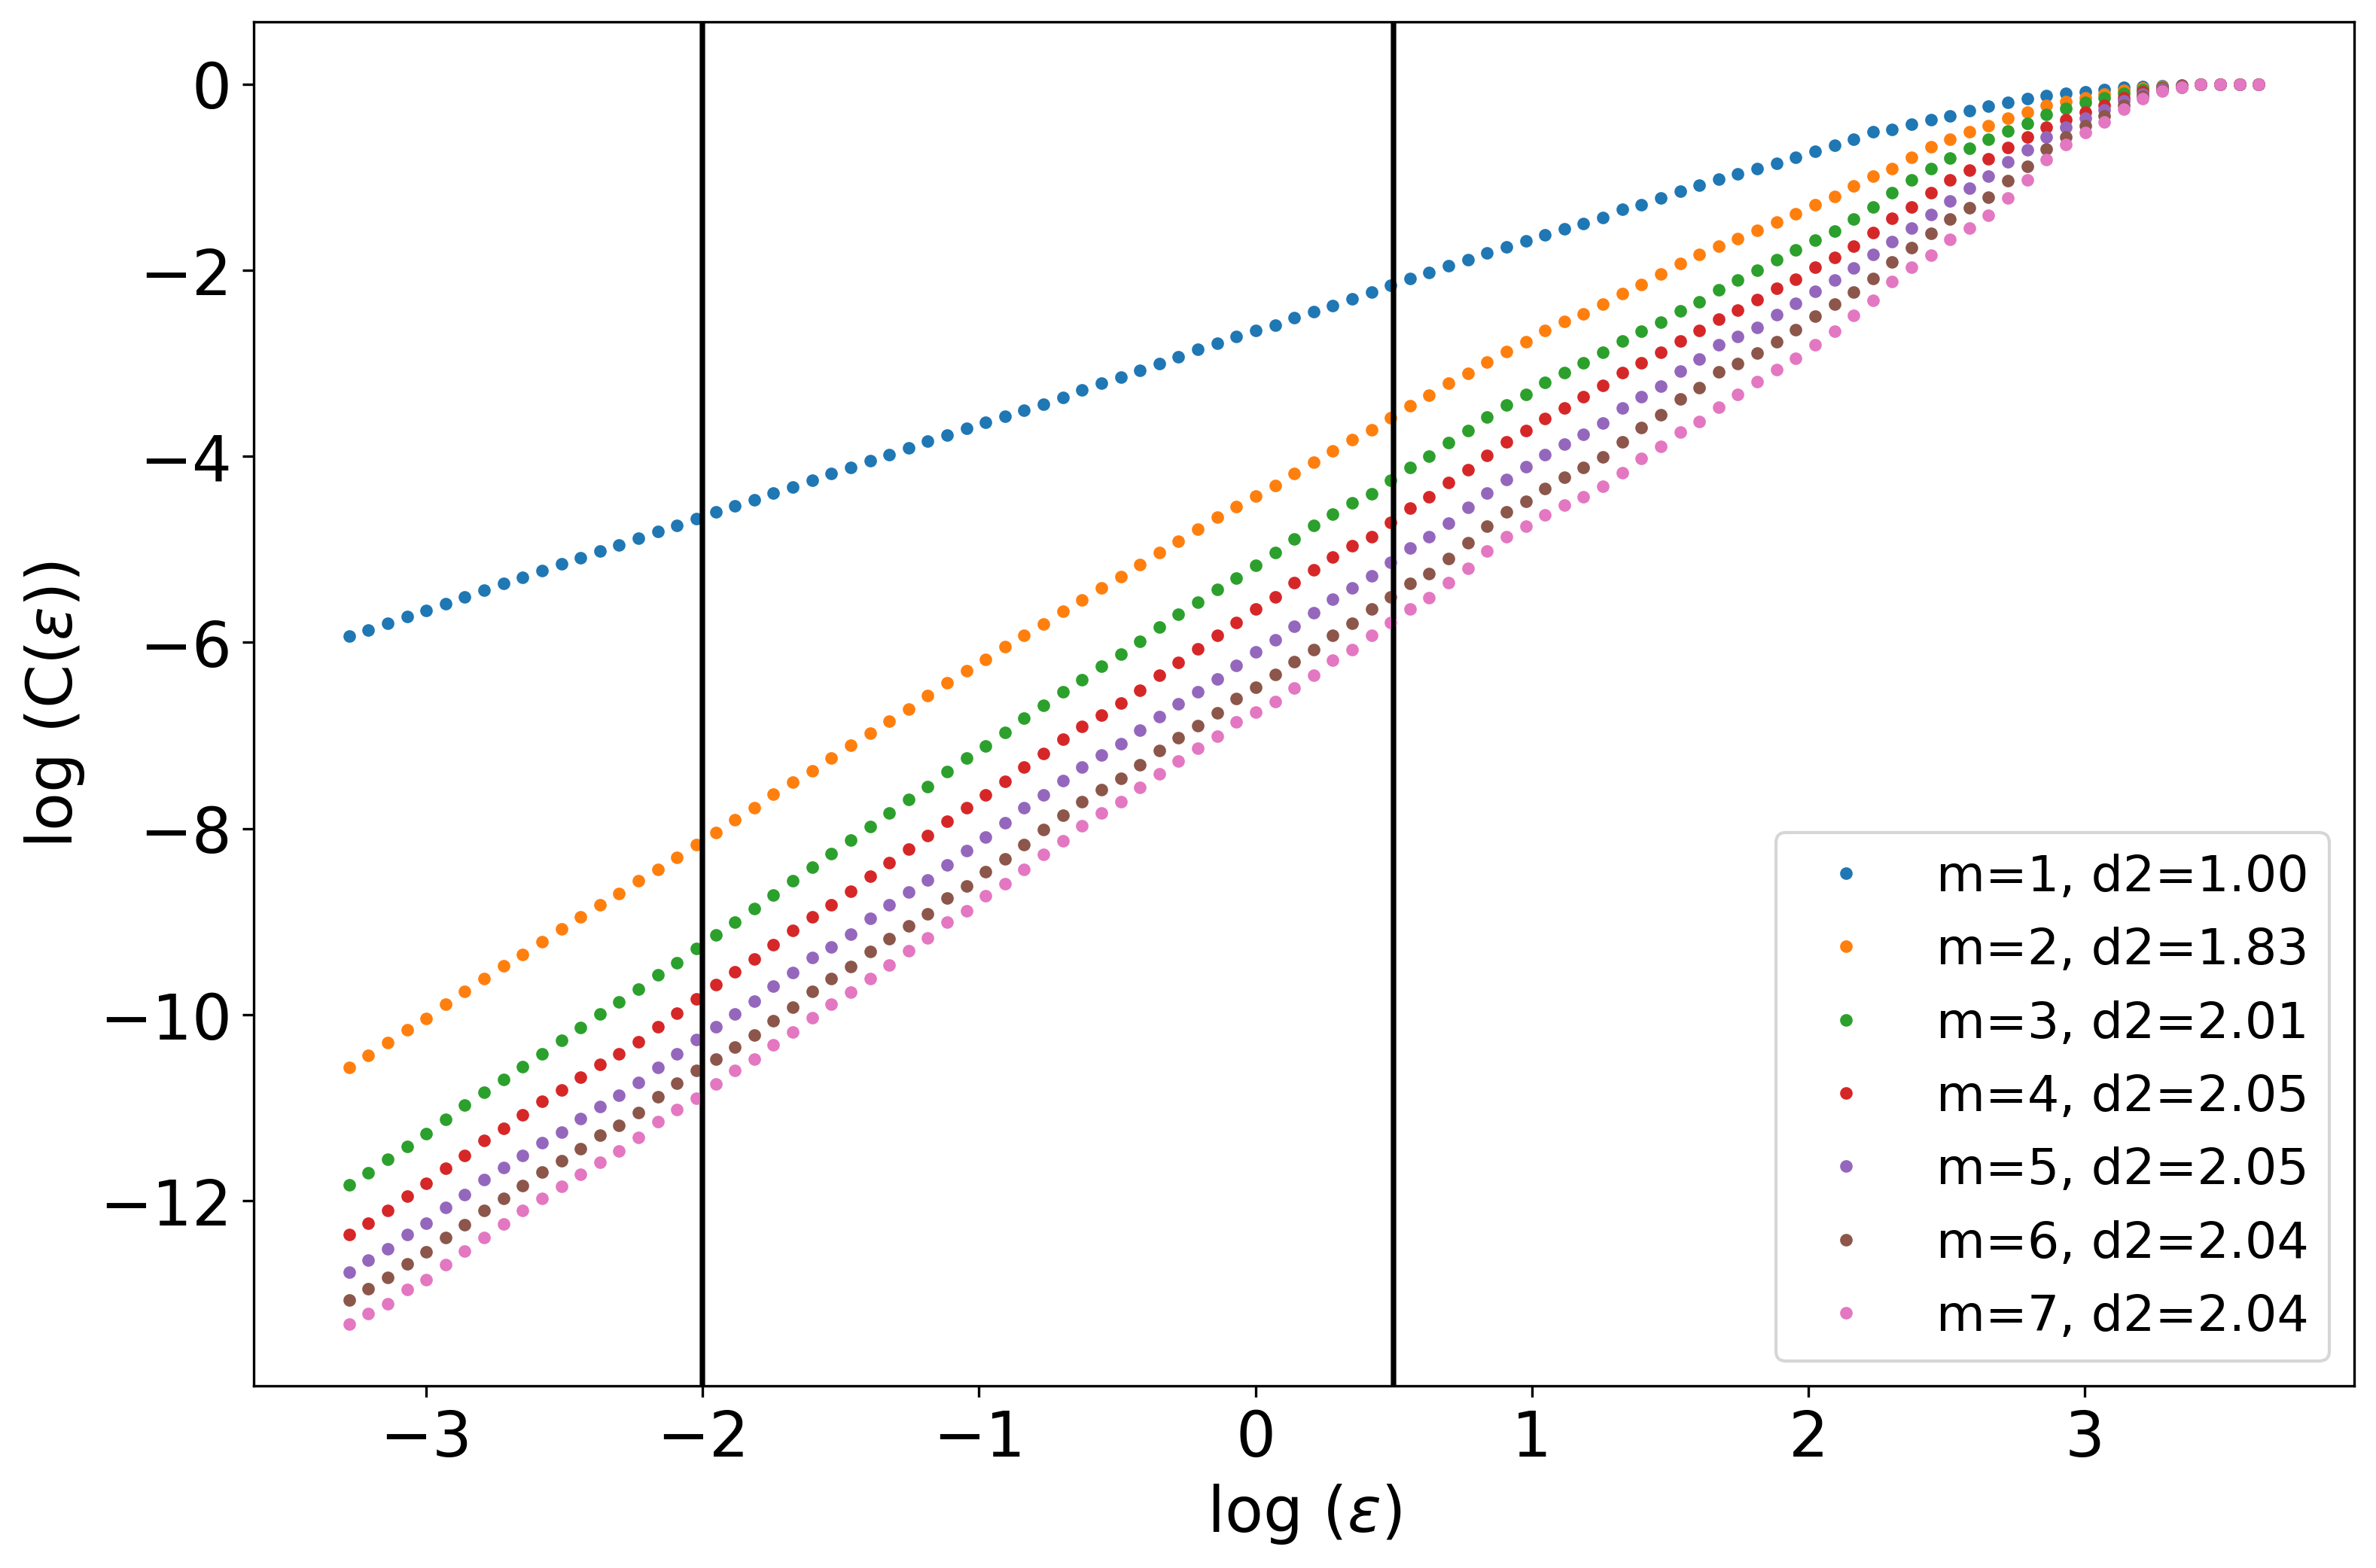

[-2.0, 0.5]
embedding dim=1, correlation dimension=1.0002718561613937+/-0.0014193974035908755
embedding dim=2, correlation dimension=1.8260177209716817+/-0.0066765391830637425
embedding dim=3, correlation dimension=2.0149015833521444+/-0.007219818934161472
embedding dim=4, correlation dimension=2.0495914672741695+/-0.005370117418711105
embedding dim=5, correlation dimension=2.0518898668386605+/-0.005570813426616264
embedding dim=6, correlation dimension=2.043525450996692+/-0.005063566386865989
embedding dim=7, correlation dimension=2.0428058702455747+/-0.0067654988012463176


In [13]:
#[t, data] = get_lorenz(1000,100000)
#series = data[:,0]
tau=18
limits = [-2.0,0.5]
#limits = [1.5,2.8]
#series = data_lorenz(0,n=n,tmax=trans)

dims = 7
theiler_window = int(2.718**limits[-1]/step_size/ds_rate)
print(theiler_window)
corr = tiseanio('d2','-d',tau,'-M','1,{}'.format(dims),'-t', theiler_window, data=lorenzTS, silent=True)

c2 = corr[0]['c2']
log_c2 = np.log(c2)
plot_d2(log_c2, dims, 'd2_figures_paper/lorenz_curvature_tau_{}_noise_{}_limits_{}_{}.png'.format(tau, noise_level, limits[0], limits[1]), limits)
fit_slopes(log_c2, dims, limits)

# Lorenz tau = 18 (Mutual)

In [ ]:
#[t, data] = get_lorenz(1000,100000)
#series = data[:,0]

#series = data_lorenz(0)
tau = 18
dims = 7
limits=[-2,.5]

theiler_window = int(2.718**limits[-1]/step_size/ds_rate)
print(theiler_window)
corr = tiseanio('d2','-d',tau,'-M','1,{}'.format(dims),'-t',theiler_window, data=lorenzTS, silent=True)

c2 = corr[0]['c2']
log_c2 = np.log(c2)
plot_d2(log_c2, dims, 'd2_figures_paper/lorenz_mutual_tau_{}_noise_{}_limits_{}_{}.png'.format(tau, noise_level, limits[0], limits[1]), limits)
fit_slopes(log_c2, dims, limits)

# Lorenz tau = 60 (Mutual)



331
Additional non-data files were created
Saving as  d2_figures_paper/lorenz_mutual_tau_60_noise_0.0_limits_-1_1.2.png


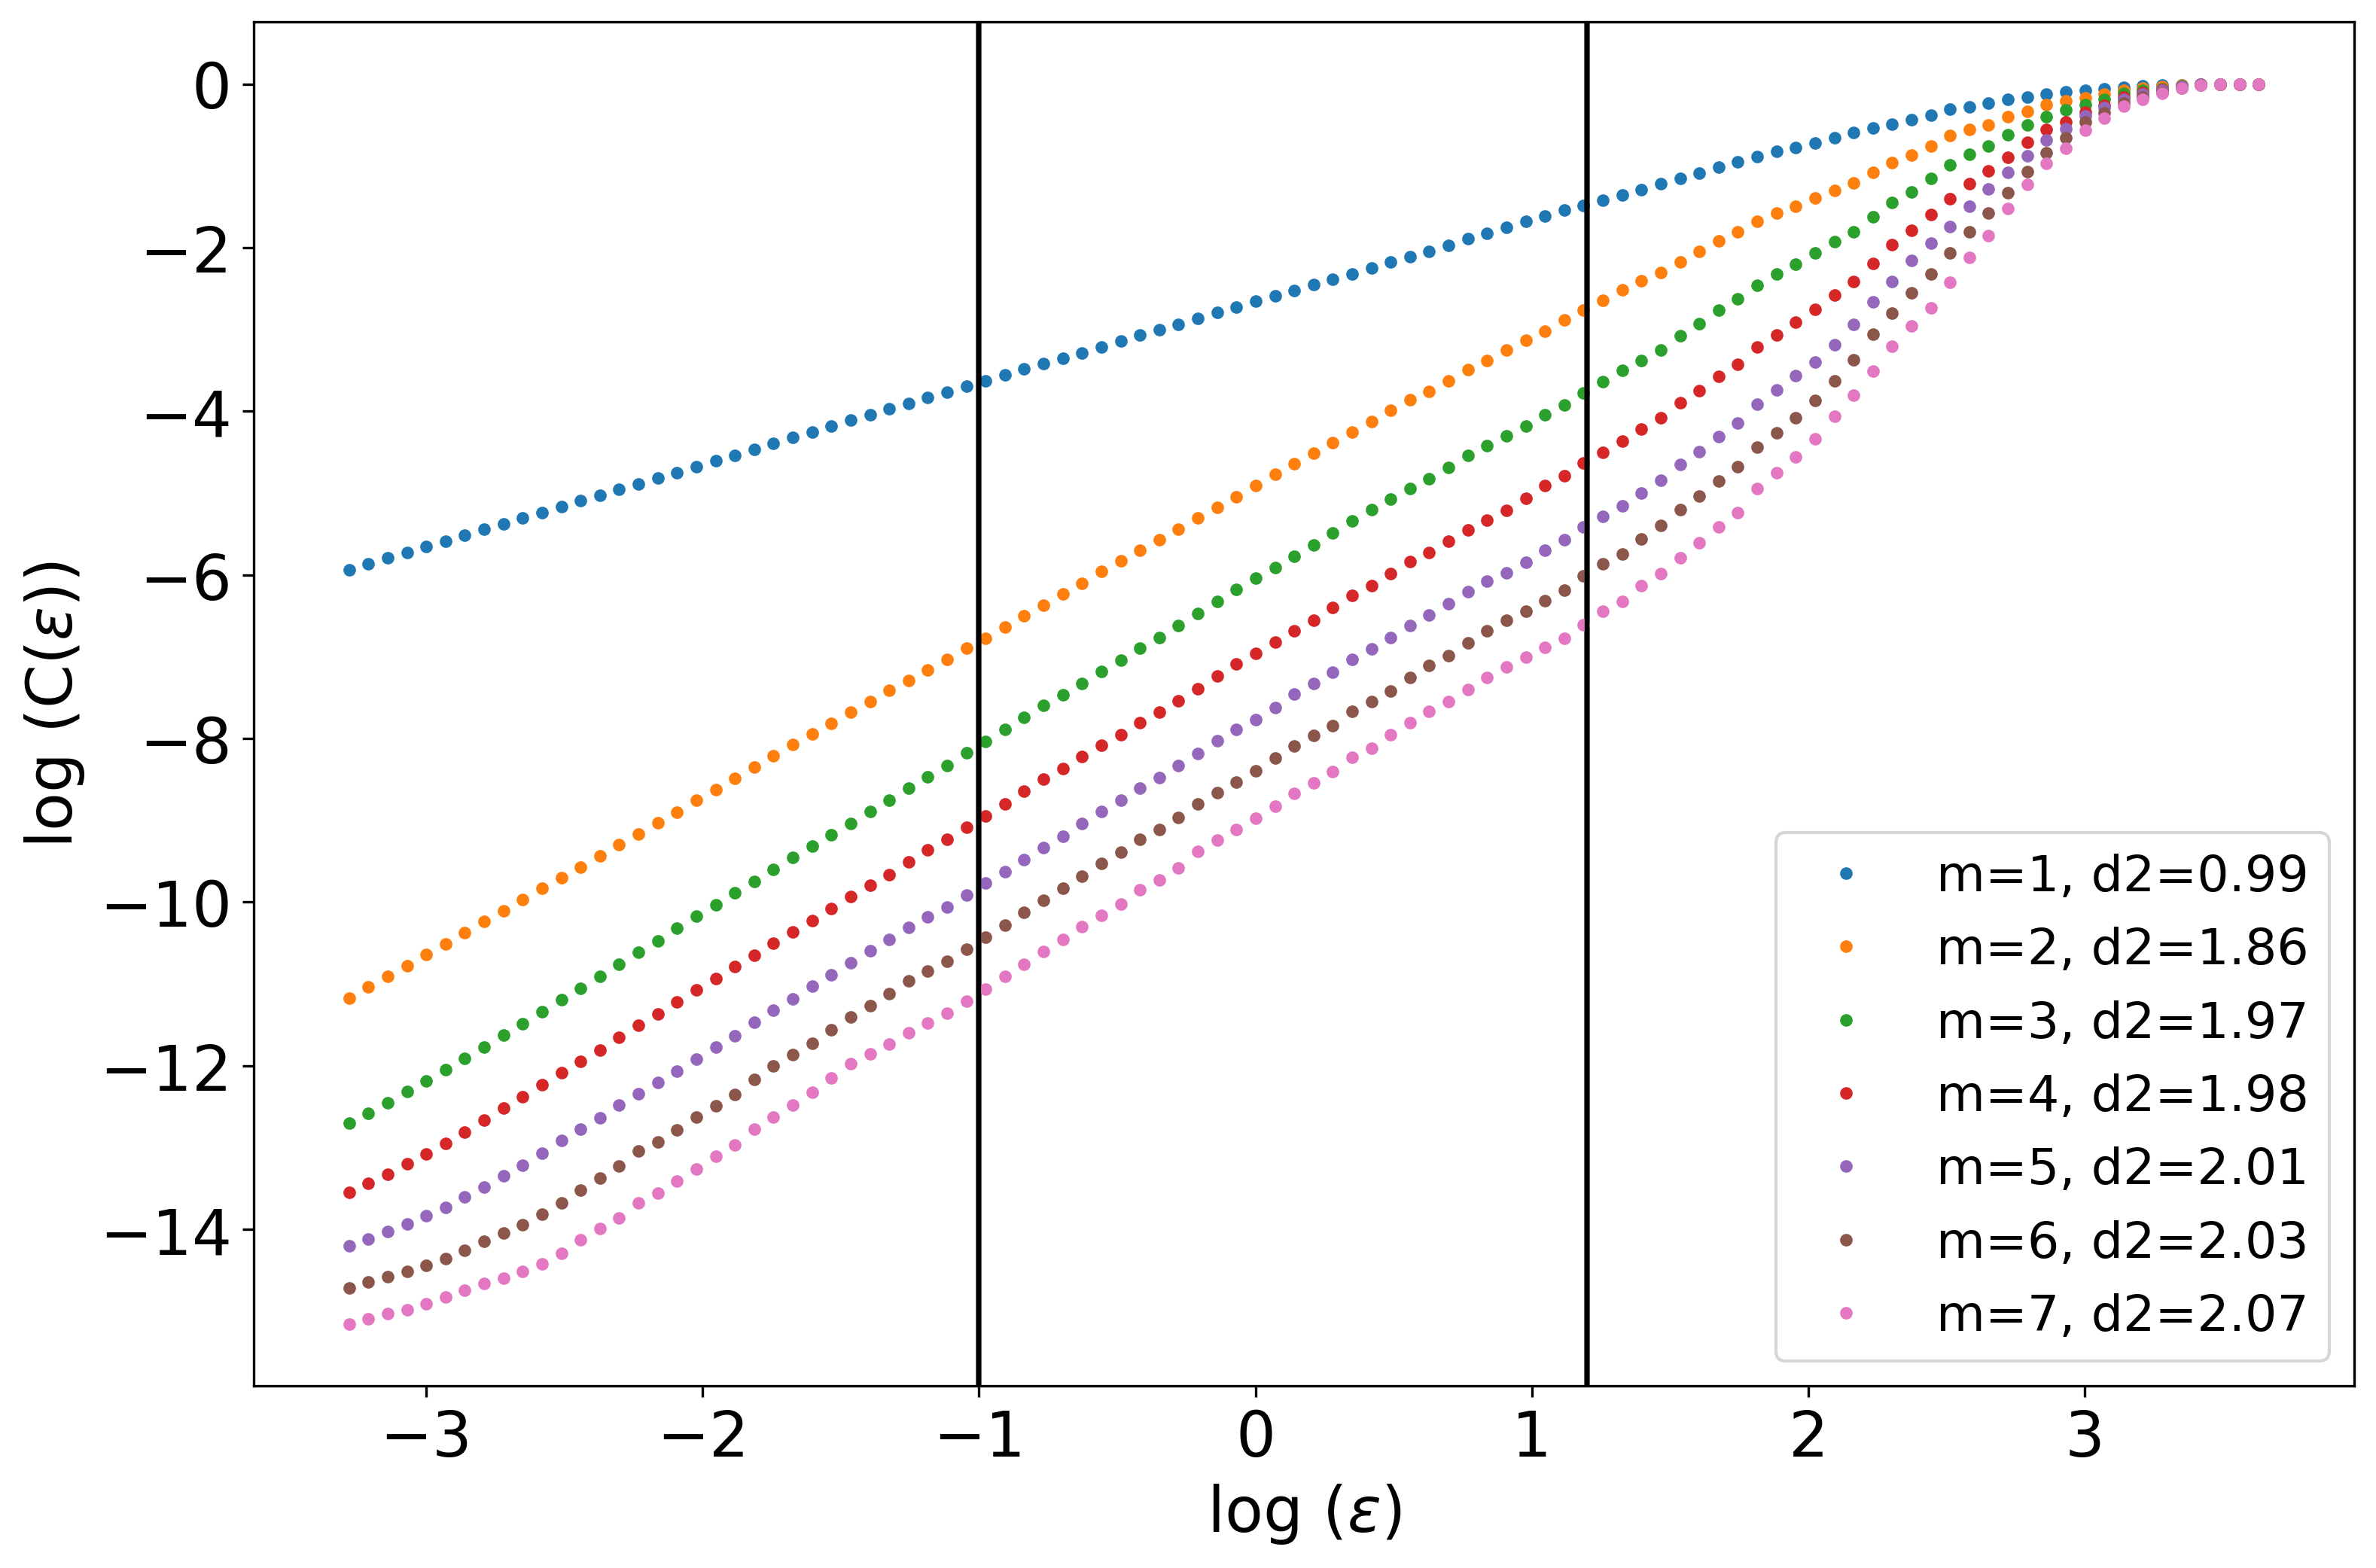

[-1, 1.2]
embedding dim=1, correlation dimension=0.992846644947156+/-0.0011826949785981027
embedding dim=2, correlation dimension=1.8567184950760296+/-0.005658690220386005
embedding dim=3, correlation dimension=1.9728665678603898+/-0.007796554788976818
embedding dim=4, correlation dimension=1.9846886321022643+/-0.0051828056515123766
embedding dim=5, correlation dimension=2.0130081395127055+/-0.006676292238467932
embedding dim=6, correlation dimension=2.0317004932577882+/-0.00587429092698492
embedding dim=7, correlation dimension=2.066239431572417+/-0.009654724959718985


In [12]:
tau = 60
dims = 7

#limits = [1.8,2.5]
limits = [-1,1.2]

#plt.figure()
#plt.plot(lorenzTS[:-tau], lorenzTS[tau:], '.', markersize=.1)
#plt.xlabel(r'$X_{t}$', fontsize=12)
#plt.ylabel(r'$X_{t+\tau}$', fontsize=12)
#plt.savefig('lorenz_reconstruction_{}_ds_rate_{}.png'.format(tau, ds_rate))

dims = 7
theiler_window = int(2.718**limits[-1]/step_size/ds_rate)
print(theiler_window)
corr = tiseanio('d2','-d',tau,'-M','1,{}'.format(dims),'-t',theiler_window, data=lorenzTS, silent=True)
c2 = corr[0]['c2']
log_c2 = np.log(c2)
plot_d2(log_c2, dims, 'd2_figures_paper/lorenz_mutual_tau_{}_noise_{}_limits_{}_{}.png'.format(tau, noise_level, limits[0], limits[1]), limits)
#plot_d2(log_c2, dims, './lorenz_mutual_tau_{}_noise_{}_limits_{}_{}.png'.format(tau, noise_level, limits[0], limits[1]), limits)
fit_slopes(log_c2, dims, limits)

331
Additional non-data files were created
Saving as  d2_figures_paper/corr/lorenz_mutual_tau_65_noise_0.0_limits_-1_1.2.png


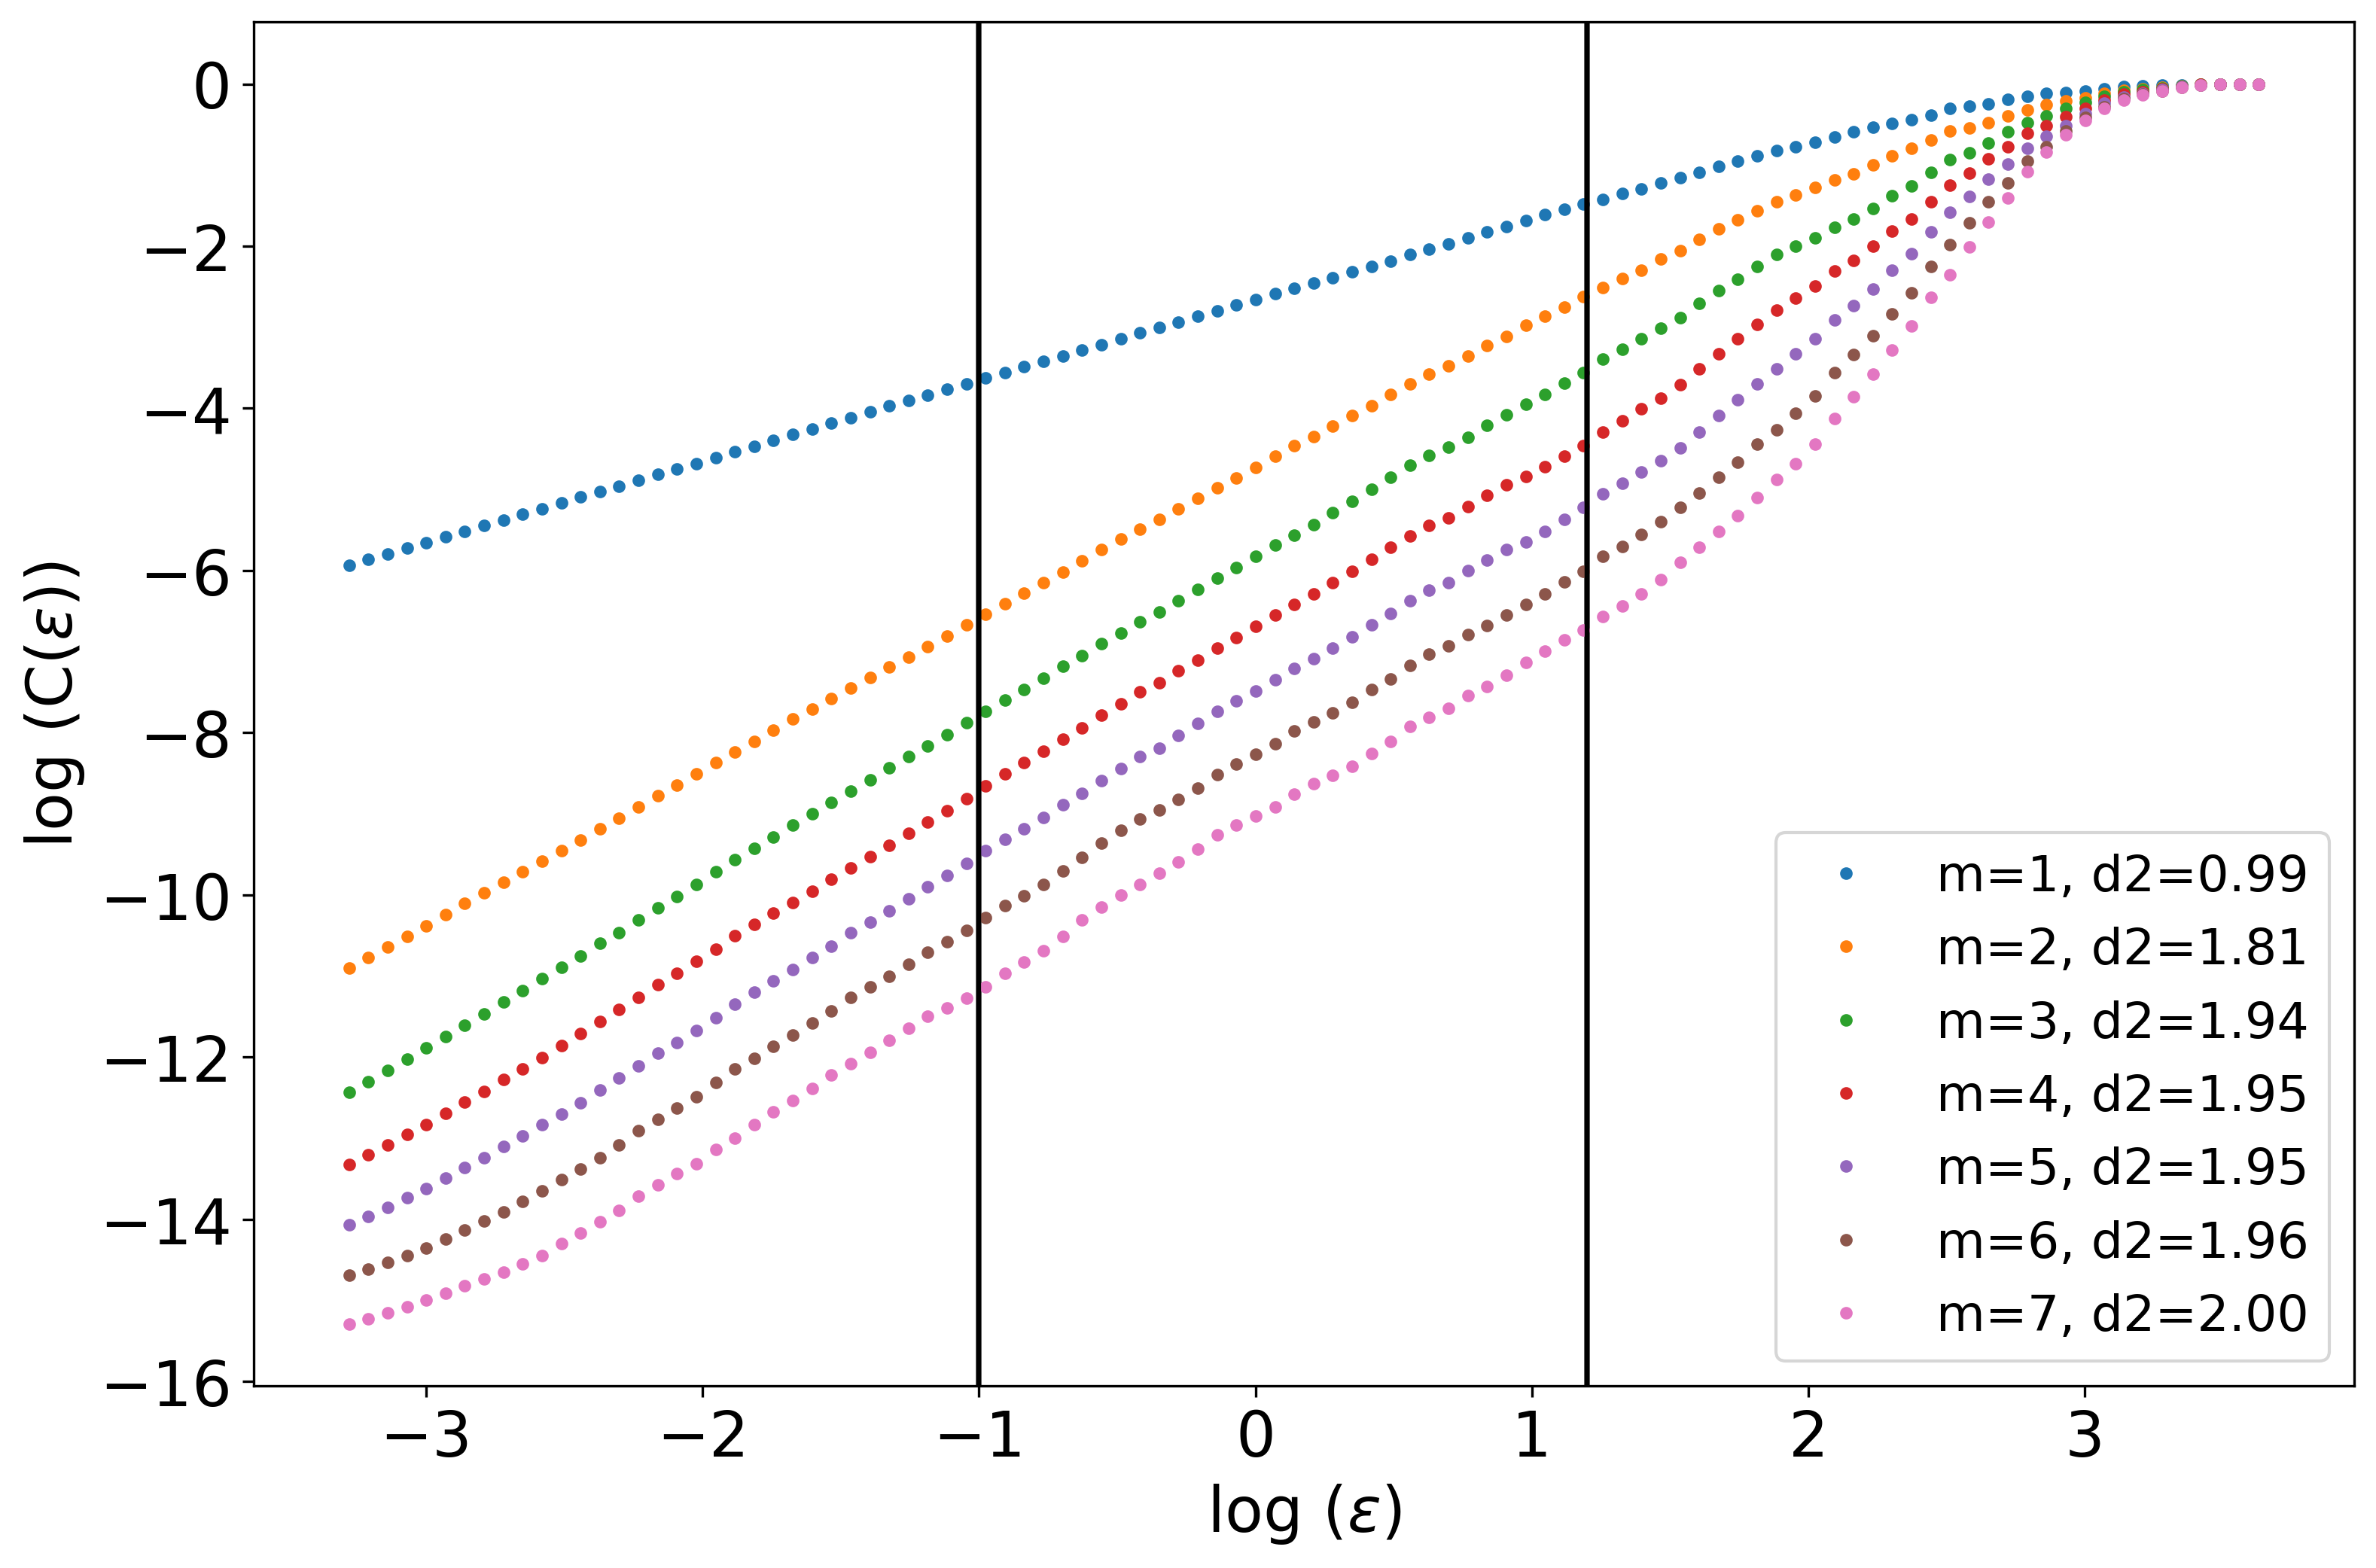

[-1, 1.2]
embedding dim=1, correlation dimension=0.991644649271226+/-0.0011292484615783615
embedding dim=2, correlation dimension=1.8128902682237067+/-0.005262832779734627
embedding dim=3, correlation dimension=1.9372675117368654+/-0.004423093256544925
embedding dim=4, correlation dimension=1.9465870404952192+/-0.00825562587047549
embedding dim=5, correlation dimension=1.953572582180706+/-0.008471580847856828
embedding dim=6, correlation dimension=1.9624218060724545+/-0.010721507845671678
embedding dim=7, correlation dimension=2.004153658667626+/-0.013276365639351131


In [29]:
tau = 65
dims = 7

#limits = [1.8,2.5]
limits = [-1,1.2]

#plt.figure()
#plt.plot(lorenzTS[:-tau], lorenzTS[tau:], '.', markersize=.1)
#plt.xlabel(r'$X_{t}$', fontsize=12)
#plt.ylabel(r'$X_{t+\tau}$', fontsize=12)
#plt.savefig('lorenz_reconstruction_{}_ds_rate_{}.png'.format(tau, ds_rate))

dims = 7
theiler_window = int(2.718**limits[-1]/step_size/ds_rate)
print(theiler_window)
corr = tiseanio('d2','-d',tau,'-M','1,{}'.format(dims),'-t',theiler_window, data=lorenzTS, silent=True)
c2 = corr[0]['c2']
log_c2 = np.log(c2)
plot_d2(log_c2, dims, 'd2_figures_paper/corr/lorenz_mutual_tau_{}_noise_{}_limits_{}_{}.png'.format(tau, noise_level, limits[0], limits[1]), limits)
#plot_d2(log_c2, dims, './lorenz_mutual_tau_{}_noise_{}_limits_{}_{}.png'.format(tau, noise_level, limits[0], limits[1]), limits)
fit_slopes(log_c2, dims, limits)

In [ ]:
fnn_curvature, err = tiseanio('false_nearest', '-D', '18', '-m', '1', '-M', '1,10', '-t', 100, data=lorenzTS, silent=True)
fnn_ami, err = tiseanio('false_nearest', '-D', '60', '-m', '1', '-M', '1,10', '-t', 100, data=lorenzTS, silent=True)

In [ ]:
plt.plot(fnn_curvature[:,1])
plt.plot(fnn_ami[:,1])

In [ ]:
plt.plot(lorenzTS[:-18], lorenzTS[18:], '.' ,markersize=.1)
plt.plot(lorenzTS[:-60], lorenzTS[60:], '.' ,markersize=.1)

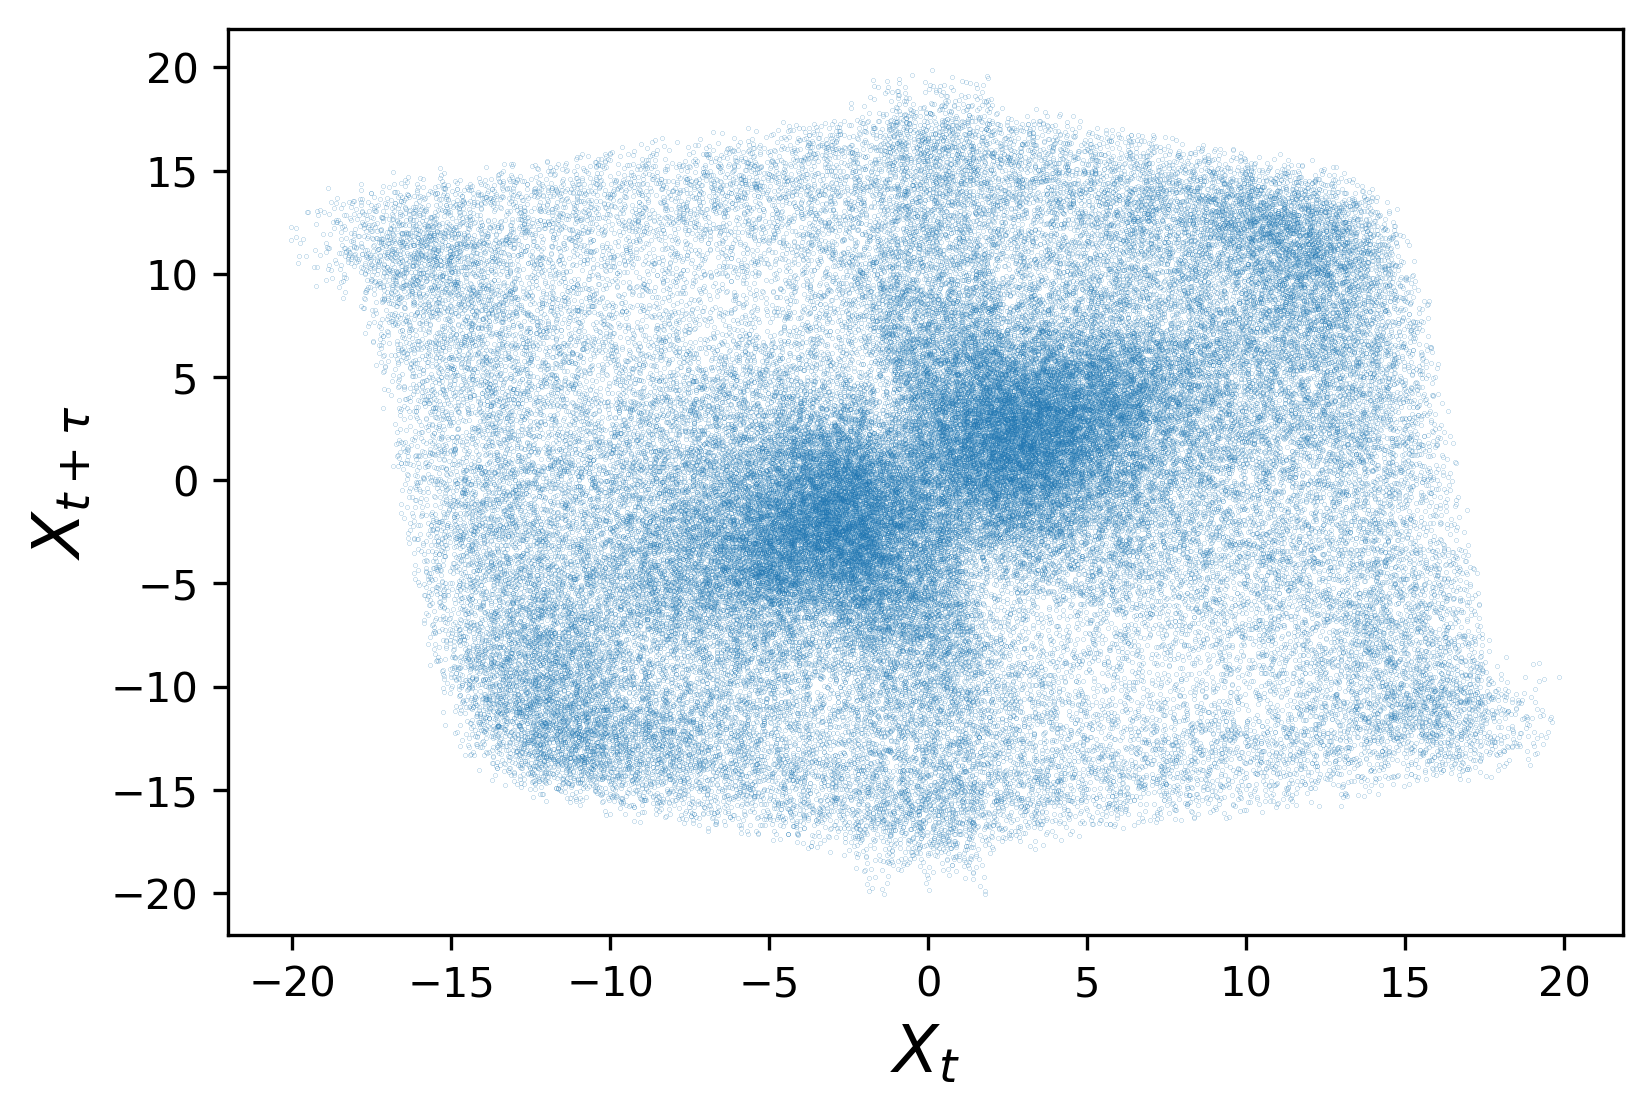

In [28]:
tau = 60
plt.figure(dpi=300)
plt.plot(lorenzTS[:-tau], lorenzTS[tau:], '.', markersize=.1)
plt.xlabel(r'$X_{t}$', fontsize=16)
plt.ylabel(r'$X_{t+\tau}$', fontsize=16)
plt.savefig('d2_figures_paper/lorenz_reconstruction_tau_{}_noise_{}.png'.format(tau, noise_level))


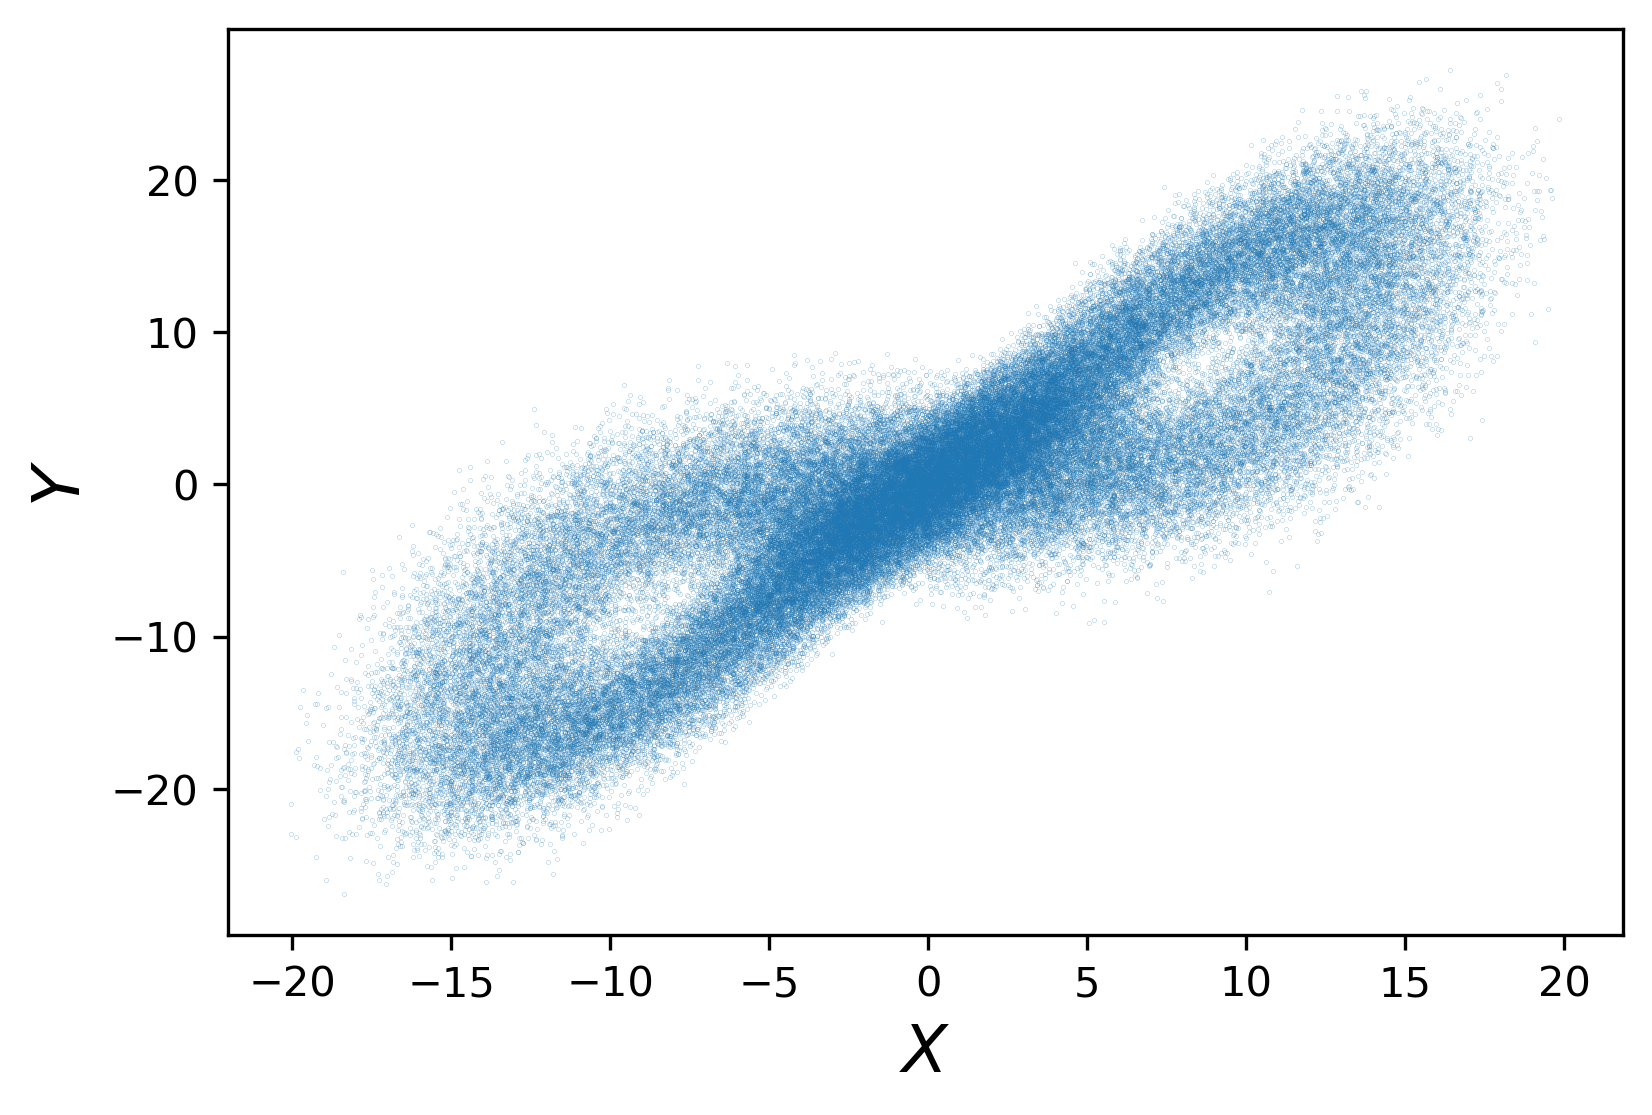

In [29]:
plt.figure(dpi=300)
plt.plot(data[:,0], data[:,1], '.', markersize=.1)
plt.xlabel(r'$X$', fontsize=16)
plt.ylabel(r'$Y$', fontsize=16)
plt.savefig('d2_figures_paper/lorenz_full_noise_{}.png'.format(noise_level))
